使用增强型WGAN生成FashionMnist数据
===

# 1.全局设置

In [1]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../")
import jjzhk.progressbar as bar

DATA_PATH = "/input/FashionMNIST/"
EPOCHS = 100
BATCH_SIZE = 64
NOISE_DIM = 100
IMAGE_CHANNEL = 1
IMAGE_SIZE = 28
LAMBDA = 0.25
LEARNING_RATE = 2e-4

In [2]:
def weight_init(net):
    for m in net.modules():
        if isinstance(m, torch.nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, torch.nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, torch.nn.BatchNorm2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
            m.bias.data.fill_(0)

# 2.模型

In [3]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(NOISE_DIM, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.ReLU()
        )

        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(1024, 128 * 7 * 7),
            torch.nn.BatchNorm1d(128 * 7 * 7),
            torch.nn.ReLU()
        )

        self.deconv1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, 64, 4, 2, 1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU()
        )

        self.deconv2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, IMAGE_CHANNEL, 4, 2, 1),
            torch.nn.Sigmoid()
        )

        weight_init(self)
    def forward(self, x):
        output = self.fc1(x)
        output = self.fc2(output)
        output = output.view(-1, 128, 7, 7)
        output = self.deconv1(output)
        output = self.deconv2(output)

        return output

class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(IMAGE_CHANNEL, 64, 4, 2, 1),
            torch.nn.LeakyReLU(0.2)
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, 4, 2, 1),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2)
        )

        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(128 * 7 * 7, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.LeakyReLU(0.2)
        )

        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(1024, 1),
            torch.nn.Sigmoid()
        )
        weight_init(self)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2(output)
        output = output.view(-1, 128 * 7 * 7)
        output = self.fc1(output)
        output = self.fc2(output)

        return output

# 3.导入数据

In [5]:
NetD = Discriminator()
NetG = Generator()
optimizerD = torch.optim.Adam(NetD.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(NetG.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
trans=tv.transforms.Compose([tv.transforms.ToTensor()])
train_dataset = tv.datasets.FashionMNIST(root=DATA_PATH,
                               train=True,
                               transform=trans,
                               download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

fix_noise     = torch.randn(100, NOISE_DIM)
fix_noise_var = torch.autograd.Variable(fix_noise)

if torch.cuda.is_available() > 0:
    NetG = NetG.cuda()
    NetD = NetD.cuda()
    fix_noise_var = fix_noise_var.cuda()

In [6]:
def calc_gradient_penalty(netD, real_data, fake_data, mini_batch):
    alpha = torch.rand(mini_batch, 1)
    alpha = alpha.expand(mini_batch, int(real_data.nelement()/mini_batch))\
        .contiguous().view(mini_batch, IMAGE_CHANNEL,IMAGE_SIZE, IMAGE_SIZE)

    if torch.cuda.is_available():
        alpha = alpha.cuda()

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    if torch.cuda.is_available():
        interpolates = interpolates.cuda()

    interpolates = torch.autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                     grad_outputs=torch.ones(disc_interpolates.size()).cuda() if torch.cuda.is_available() else torch.ones(
                         disc_interpolates.size()),
                     create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

# 4.训练

In [7]:
showbar = bar.ProgressBar(EPOCHS, len(train_loader), "D Loss:%.3f;G Loss:%.3f")
for epoch in range(1, EPOCHS + 1):
    for index, (image, label) in enumerate(train_loader):
        mini_batch = image.shape[0]
        noise = torch.rand(mini_batch, NOISE_DIM)

        real_var = torch.autograd.Variable(image)
        noise_var = torch.autograd.Variable(noise)
        alpha = torch.rand(mini_batch)

        if torch.cuda.is_available():
            real_var = real_var.cuda()
            noise_var = noise_var.cuda()
            alpha = alpha.cuda()

        NetD.zero_grad()

        D_real = NetD(real_var)
        D_real_loss = -torch.mean(D_real)

        G_ = NetG(noise_var)
        D_fake = NetD(G_)
        D_fake_loss = torch.mean(D_fake)

        gradient_penalty = calc_gradient_penalty(NetD, real_var.data, G_.data, mini_batch)
        D_loss = D_real_loss + D_fake_loss + gradient_penalty
        D_loss.backward()
        optimizerD.step()

        G_loss = D_loss
        if ((index+1) % 5) == 0:
            # update G network
            NetG.zero_grad()

            G_ = NetG(noise_var)
            D_fake = NetD(G_)
            G_loss = -torch.mean(D_fake)

            G_loss.backward()
            optimizerG.step()

        showbar.show(epoch, D_loss.item(), G_loss.item())

Epoch:1 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:-0.983;G Loss:-0.983,total=0:01:350
Epoch:2 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:-0.994;G Loss:-0.994,total=0:01:37025:36
Epoch:3 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:-0.995;G Loss:-0.995,total=0:01:37025:449
Epoch:4 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:-0.996;G Loss:-0.996,total=0:01:37024:401
Epoch:5 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:-0.995;G Loss:-0.995,total=0:01:38023:083
Epoch:6 / 100 [***************************************************************************************

Epoch:45 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:-0.732;G Loss:-0.732,total=0:02:120007:4914
Epoch:46 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:-0.760;G Loss:-0.760,total=0:02:070514:2241
Epoch:47 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:-0.676;G Loss:-0.676,total=0:02:100020:4550
Epoch:48 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:-0.596;G Loss:-0.596,total=0:02:120300:4446
Epoch:49 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:-0.816;G Loss:-0.816,total=0:02:120407:2290
Epoch:50 / 100 [****************************************************************

Epoch:89 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:-0.424;G Loss:-0.424,total=0:02:1002:05:5027
Epoch:90 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:-0.448;G Loss:-0.448,total=0:02:1207:07:2644
Epoch:91 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:-0.470;G Loss:-0.470,total=0:02:0106:09:158
Epoch:92 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:-0.500;G Loss:-0.500,total=0:02:0409:09:2764
Epoch:93 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:-0.475;G Loss:-0.475,total=0:02:1201:10:1111
Epoch:94 / 100 [************************************************************

# 5.生成数据

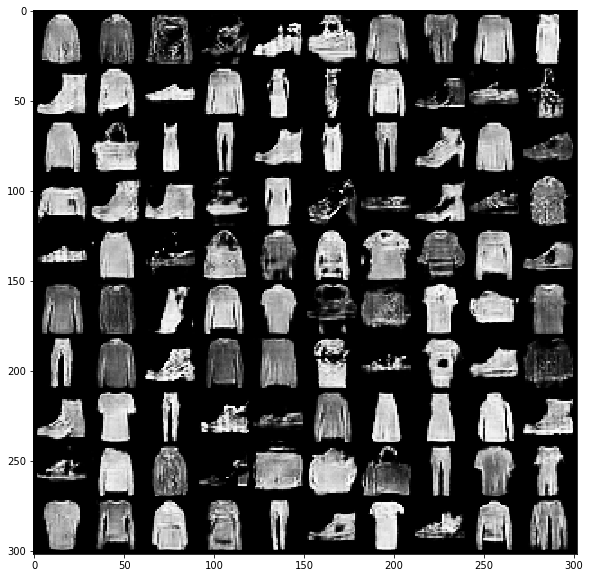

In [8]:
fake_u=NetG(fix_noise_var)
img = tv.utils.make_grid(fake_u.data[:100], nrow=10, normalize=True)
plt.figure(figsize=(10,10), facecolor='w')
plt.imshow(np.transpose(img.cpu(), (1, 2, 0)))